# Recommender Systems (Movie Reviews)
- Author: Chris Hodapp
- Date: 2018-02-04

This was done as part of a [SharpestMinds](https://www.sharpestminds.com/) skills test that was left fairly open-ended, but for which the goal was to build a recommender system for movie reviews.  It's based around the [movielens 100k](https://grouplens.org/datasets/movielens/100k/) dataset, and the code below assumes that `ml-100k` from there has been downloaded and uncompressed in the local directory.

In addition to the normal steps of loading data and doing basic transformations, this works through implementations of:

- Slope One Predictors - a collaborative filtering method, particularly, a neighborhood model.
- An "SVD" algorithm which [Simon Funk](http://sifter.org/~simon/journal/20061211.html) popularized for the Netflix prize - another collaborative filtering method, this one a latent factor model based on matrix factorization.

It also reproduces similar results with [scikit-surprise](http://surpriselib.com/), which implements these algorithms (and many others).

## TODOs

- Bipolar Slope One?
- Read Netflix post
- Content-based filtering?
- Maybe implement something easy like NMF?
- Finish blog post and link to it
- Visualization of latent factors
- Explain code a bit better (ditch the formal Python version)
- Put utility matrix someplace else since I only need it for Slope One
- How far separate should this be from the Slope One blog post?
  - Why don't I just export it to Markdown, merge in all the Slope One post content, and put this file on my blag as well?

## Loading data

In [1]:
import pandas as pd
import numpy as np
import sklearn.model_selection

In [2]:
ml = pd.read_csv("ml-100k/u.data", sep="\t", header=None,
                 names=("user_id", "movie_id", "rating", "time"))
# Convert Unix seconds to a Pandas timestamp:
ml["time"] = pd.to_datetime(ml["time"], unit="s")

In [3]:
ml[:10]

,user_id,movie_id,rating,time
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16
5,298,474,4,1998-01-07 14:20:06
6,115,265,2,1997-12-03 17:51:28
7,253,465,5,1998-04-03 18:34:27
8,305,451,3,1998-02-01 09:20:17
9,6,86,3,1997-12-31 21:16:53


In [4]:
ml.shape

(100000, 4)

In [5]:
max_user  = int(ml["user_id"].max() + 1)
max_movie = int(ml["movie_id"].max() + 1)
max_user, max_movie, max_user * max_movie

(944, 1683, 1588752)

To get an idea of data sparsity:

In [6]:
ml.shape[0] / (max_user * max_movie)

0.06294248567429025

## Aggregation

We need an average rating value for some models, but it might make more sense to have that average be weighted by the movie's popularity in some fashion.  Also, we read in the list of movie names below in order to get some more comprehensible information out of this later on.

In [7]:
names = pd.read_csv(
    "ml-100k/u.item", sep="|", header=None,
    encoding = "ISO-8859-1", index_col=0,
    names=("movie_id", "movie_title"), usecols=[0,1])

In [8]:
movie_group = ml.groupby("movie_id")
movie_stats = names.\
    join(movie_group.size().rename("num_ratings")).\
    join(movie_group.mean()["rating"].rename("avg_rating"))

Sorting by number of ratings and looking at the movie titles, this looks pretty sensible:

In [9]:
movie_stats.sort_values("num_ratings", ascending=False)[:20]

,movie_title,num_ratings,avg_rating
movie_id,,,
50,Star Wars (1977),583,4.358491
258,Contact (1997),509,3.803536
100,Fargo (1996),508,4.155512
181,Return of the Jedi (1983),507,4.007890
294,Liar Liar (1997),485,3.156701
286,"English Patient, The (1996)",481,3.656965
288,Scream (1996),478,3.441423
1,Toy Story (1995),452,3.878319
300,Air Force One (1997),431,3.631090


## Training/testing split:

In [10]:
ml_train, ml_test = sklearn.model_selection.train_test_split(ml, test_size=0.25)

## Conversion to utility matrix:

We need a mask for some later steps, hence the m > 0 step; ratings go only from 1 to 5, so values of 0 are automatically unknown/missing data.

In [11]:
def df2mat(df):
    m = np.zeros((max_user, max_movie))
    m[df["user_id"], df["movie_id"]] = df["rating"]
    return m, m > 0
ml_mat_train, ml_mask_train = df2mat(ml_train)
ml_mat_test,  ml_mask_test  = df2mat(ml_test)

If this were an actual large amount of data, which a 944x1683 matrix doesn't really count as, you'd probably want [sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html) and to use 8-bit ints rather than 32-bit floats, for instance:

```python
ml_mat = scipy.sparse.coo_matrix(
    (ml["rating"], (ml["user_id"], ml["movie_id"])),
    shape=(max_user, max_movie),
    dtype=np.int8)
```

## Slope One implementation

- Based on:  [Slope One Predictors for Online Rating-Based Collaborative Filtering](https://arxiv.org/pdf/cs/0702144v1.pdf)
- TODO: This needs better explanation but I'm not sure if it should reside here, in the Python code, or in the blag post

In [12]:
def deviation(M, mask):
    m,n = M.shape
    m2 = mask.astype(np.int)
    counts = m2.T @ m2
    S = m2.T @ M
    diffs = S.T - S
    dev = diffs / np.maximum(1, counts)
    return dev, counts

The implementation of 'deviation' above might be less-optimal vastly larger matrices. For one thing, Slope One doesn't really *need* a utility matrix, though it's easier from one. One could readily compute deviation from the list of ratings, though I don't know a fast way to do this.

In [13]:
def predict_one(M, mask, dev, counts, u, j, weighted = False):
    m,n = M.shape
    # S_u is a mask over M's columns for items user 'u' rated:
    S_u = mask[u, :]
    if weighted:
        # In 'Weighted Slope One', we sum over everything user 'u' rated,
        # regardless of whether other users rated both this and item j:
        S_u[j] = False
        c_j = counts[j, S_u]
        devs = dev[j, S_u]
        u = M[u, S_u]
        return ((devs + u) * c_j).sum() / max(1.0, c_j.sum())
    else:
        # In the 'Slope One' formula we are summing over R_j, which is:
        # Every item 'i' (i != j), such that: user 'u' rated item 'i', and
        # at least one other user rated both item 'i' and item 'j'.
        # Below we compute this likewise as a mask over M's columns:
        R_j = S_u * (counts[u, :] > 0)
        R_j[j] = False
        u = M[u, R_j].sum()
        devs = dev[j, R_j].sum()
        card = max(1.0, R_j.sum())
        return (u + devs) / card

In [14]:
def predict(M, mask, dev, counts, dataframe, weighted=False):
    err_mae = 0
    err_rms = 0
    for row in dataframe.itertuples():
        p = predict_one(M, mask, dev, counts,
                        row.user_id, row.movie_id, weighted=weighted)
        err_mae += np.abs(p - row.rating)
        err_rms += np.square(p - row.rating)
    err_mae = err_mae / len(dataframe)
    err_rms = np.sqrt(err_rms / len(dataframe))
    return err_mae, err_rms

In [15]:
# Compute deviation (which is basically our model) from training:
dev, counts = deviation(ml_mat_train, ml_mask_train)

In [16]:
err_mae_train, err_rms_train = predict(ml_mat_train, ml_mask_train, dev, counts, ml_train)
err_mae_test,  err_rms_test  = predict(ml_mat_test,  ml_mask_test,  dev, counts, ml_test)

In [17]:
print("Training error: MAE={}, RMS={}".format(err_mae_train, err_rms_train))
print("Testing error: MAE={}, RMS={}".format(err_mae_test, err_rms_test))

Training error: MAE=0.6622592542046746, RMS=0.8482730775306696
Testing error: MAE=0.7635398068750631, RMS=0.9791007358992831


### Weighted Slope One

In [18]:
err_mae_train, err_rms_train = predict(ml_mat_train, ml_mask_train, dev, counts, ml_train, True)
err_mae_test,  err_rms_test  = predict(ml_mat_test,  ml_mask_test,  dev, counts, ml_test,  True)
# why must I pass both dataframe and matrix?

In [19]:
print("Training error: MAE={}, RMS={}".format(err_mae_train, err_rms_train))
print("Testing error: MAE={}, RMS={}".format(err_mae_test, err_rms_test))

Training error: MAE=0.7370283430274306, RMS=0.9861390461699144
Testing error: MAE=0.9037929843380336, RMS=1.2446873704274657


## "SVD" based algorithm

References on this can be found in a few places.  [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) in Surprise gives enough formulas to implement from. Simon Funk's post [Netflix Update: Try This at Home](http://sifter.org/~simon/journal/20061211.html) is an excellent overview of the rationale and of some practical concerns on how to run this on the much larger Netflix dataset (100,000,000 ratings, instead of 100,000). The paywalled article [Matrix Factorization Techniques for Recommender Systems](http://ieeexplore.ieee.org/abstract/document/5197422/) gives a little background from a higher level.

It is also a fairly simple algorithm, but its naming (or lack thereof) is a little confusing. Despite being called an "SVD" algorithm, it doesn't exactly compute Singular Value Decomposition, but it's SVD-like. It is still more or less a [matrix completion](https://en.wikipedia.org/wiki/Matrix_completion) problem - but it is a bit different from many matrix completion methods that explicitly use SVD, like [altMinSense & altMinComplete](https://arxiv.org/pdf/1212.0467), which [matrix-completion-whirlwind](https://github.com/asberk/matrix-completion-whirlwind/blob/master/matrix_completion_master.ipynb) has an excellent explanation and implementation of.

In short: This algorithm performs matrix completion via low-rank matrix factorization.  It does that factorization via [stochastic gradient-descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), and it does it without explicitly creating a utility matrix.

(TODO: Explain utility matrix.)

(TODO: Explain what matrices it's even building.)

For completeness (and to verify it myself), I give the model and derive its gradients here.

The prediction model is:

$$\hat{r}_{ui}=\mu + b_i + b_u + q_i^\top p_u$$

where $u$ is a user, $i$ is an item, $\mu$ is the overall average rating, $b_i$ and $b_u$ are per-item and per-user deviations respectively, and $q_i$ and $p_u$ are feature vectors.

The goal is to minimize $L_2$-regularized squared error:

$$E=\sum_{r_{ui} \in R_{\textrm{train}}} \left(r_{ui} - \hat{r}_{ui}\right)^2 + \lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right)$$

This is easily differentiable with respect to model parameters $b_i$, $b_u$, $q_i$, and $p_u$, so a normal approach is gradient-descent.  Finding gradient with respect to $b_i$ is straightforward:

$$
\begin{split}
\frac{\partial E}{\partial b_i} &= \sum_{r_{ui}} \frac{\partial}{\partial b_i} \left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)^2 + \frac{\partial}{\partial b_i}\lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right) \\
\frac{\partial E}{\partial b_i} &= \sum_{r_{ui}} 2\left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)(-1) + 2 \lambda b_i \\
\frac{\partial E}{\partial b_i} &= 2 \sum_{r_{ui}} \left(\lambda b_i + r_{ui} - \hat{r}_{ui}\right)
\end{split}
$$

Gradient with respect to $p_u$ proceeds similarly:

$$
\begin{split}
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} \frac{\partial}{\partial p_u} \left(r_{ui} - (\mu + b_i + b_u + q_i^\top p_u)\right)^2 + \frac{\partial}{\partial p_u}\lambda\left(b_i^2+b_u^2 + \lvert\lvert q_i\rvert\rvert^2 + \lvert\lvert p_u\rvert\rvert^2\right) \\
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} 2\left(r_{ui} - \hat{r}_{ui}\right)\left(-\frac{\partial}{\partial
p_u}q_i^\top p_u \right) + 2 \lambda p_u \\
\frac{\partial E}{\partial p_u} &= \sum_{r_{ui}} 2\left(r_{ui} - \hat{r}_{ui}\right)(-q_i^\top) + 2 \lambda p_u \\
\frac{\partial E}{\partial p_u} &= 2 \sum_{r_{ui}} \lambda p_u - \left(r_{ui} - \hat{r}_{ui}\right)q_i^\top
\end{split}
$$

Gradient with respect to $b_u$ is identical form to $b_i$, and gradient with respect to $q_i$ is identical form to $p_u$, except that the variables switch places.  The full gradients then have the standard form for gradient descent, i.e. a summation of a gradient term for each individual data point, so they turn easily into update rules for each parameter (which match the ones in the Surprise link) after absorbing the leading 2 into learning rate $\gamma$ and separating out the summation over each data point. That's given below, with $e_{ui}=r_{ui} - \hat{r}_{ui}$:

$$
\begin{split}
\frac{\partial E}{\partial b_i} &= 2 \sum_{r_{ui}} \left(\lambda b_i + e_{ui}\right)\ \ \ &\longrightarrow b_i' &= b_i - \gamma\frac{\partial E}{\partial b_i} &= b_i + \gamma\left(e_{ui} - \lambda b_u \right) \\
\frac{\partial E}{\partial b_u} &= 2 \sum_{r_{ui}} \left(\lambda b_u + e_{ui}\right)\ \ \ &\longrightarrow b_u' &= b_u - \gamma\frac{\partial E}{\partial b_u} &= b_u + \gamma\left(e_{ui} - \lambda b_i \right)\\
\frac{\partial E}{\partial p_u} &= 2 \sum_{r_{ui}} \lambda p_u - e_{ui}q_i^\top\ \ \ &\longrightarrow p_u' &= p_u - \gamma\frac{\partial E}{\partial p_u} &= p_u + \gamma\left(e_{ui}q_i - \lambda p_u \right) \\
\frac{\partial E}{\partial q_i} &= 2 \sum_{r_{ui}} \lambda q_i - e_{ui}p_u^\top\ \ \ &\longrightarrow q_i' &= q_i - \gamma\frac{\partial E}{\partial q_i} &= q_i + \gamma\left(e_{ui}p_u - \lambda q_i \right) \\
\end{split}
$$

Below is a pretty direct implementation of this.

In [20]:
# Hyperparameters (using Surprise defaults):
gamma = 0.005
lambda_ = 0.02
factors = 100
num_epochs = 20

In [31]:
class SVDModel(object):
    def __init__(self, num_items, num_users, mean,
                 num_factors = 100, init_variance = 0.1):
        self.mu = mean
        self.num_items = num_items
        self.num_users = num_users
        self.num_factors = num_factors
        # Deviations, per-item:
        self.b_i = np.zeros((num_items,))
        # Deviations; per-user:
        self.b_u = np.zeros((num_users,))
        # Factor matrices:
        self.q = np.random.randn(num_factors, num_items) * init_variance
        self.p = np.random.randn(num_factors, num_users) * init_variance
        # N.B. row I of q is item I's "concepts", so to speak;
        # column U of p is how much user U belongs to each "concept"
    
    def predict(self, items, users):
        """Returns rating prediction for specific items and users.

        Parameters:
        items -- 1D array of item IDs
        users -- 1D array of user IDs (same length as :items:)
        
        Returns:
        ratings -- 1D array of predicted ratings (same length as :items:)
        """
        # Note that we don't multiply p & q like matrices here,
        # but rather, we just do row-by-row dot products.
        # Matrix multiply would give us every combination of item and user,
        # which isn't what we want.
        return self.mu + \
               self.b_i[items] + \
               self.b_u[users] + \
               (self.q[:, items] * self.p[:, users]).sum(axis=0)
    
    def error(self, items, users, ratings):
        """Predicts over the given items and users, compares with the correct
        ratings, and returns RMSE and MAE.
        
        Parameters:
        items -- 1D array of item IDs
        users -- 1D array of user IDs (same length as :items:)
        ratings -- 1D array of 'correct' item ratings (same length as :items:)
        
        Returns:
        rmse, mae -- Scalars for RMS error and mean absolute error
        """
        p = self.predict(items, users)
        d = p - ratings
        rmse = np.sqrt(np.square(d).sum() / items.size)
        mae = np.abs(d).sum() / items.size
        return rmse, mae
    
    def update_by_gradient(self, i, u, r_ui, lambda_, gamma):
        """Perform a single gradient-descent update."""
        e_ui = r_ui - self.predict(i, u)
        dbi = gamma * (e_ui - lambda_ * self.b_u[u])
        dbu = gamma * (e_ui - lambda_ * self.b_i[i])
        dpu = gamma * (e_ui * self.q[:,i] - lambda_ * self.p[:, u])
        dqi = gamma * (e_ui * self.p[:,u] - lambda_ * self.q[:, i])
        self.b_i[i] += dbi
        self.b_u[u] += dbu
        self.p[:,u] += dpu
        self.q[:,i] += dqi
    
    def train(self, items, users, ratings, gamma = 0.005, lambda_ = 0.02,
              num_epochs=20, epoch_callback=None):
        """Train with stochastic gradient-descent"""
        for epoch in range(num_epochs):
            for idx in np.random.permutation(len(items)):
                i, u, r_ui = items[idx], users[idx], ratings[idx]
                self.update_by_gradient(i, u, r_ui, lambda_, gamma)
            if epoch_callback: epoch_callback(self, epoch, num_epochs)

In [ ]:
movies_train = ml_train["movie_id"].values
users_train = ml_train["user_id"].values
ratings_train = ml_train["rating"].values
movies_test = ml_test["movie_id"].values
users_test = ml_test["user_id"].values
ratings_test = ml_test["rating"].values
def at_epoch(self, epoch, num_epochs):
    train_rmse, train_mae = self.error(movies_train, users_train, ratings_train)
    test_rmse, test_mae = self.error(movies_test, users_test, ratings_test)
    print("Epoch {:02d}/{}; Training: MAE={:.3f} RMSE={:.3f}, Testing: MAE={:.3f} RMSE={:.3f}".
          format(epoch + 1, num_epochs, train_mae, train_rmse, test_mae, test_rmse))

In [33]:
svd100 = SVDModel(max_movie, max_user, ml["rating"].mean(), num_factors=100)
svd100.train(movies_train, users_train, ratings_train, epoch_callback=at_epoch)

Epoch 01/20; Training: MAE=0.803 RMSE=0.993, Testing: MAE=0.821 RMSE=1.012
Epoch 02/20; Training: MAE=0.760 RMSE=0.952, Testing: MAE=0.789 RMSE=0.985
Epoch 03/20; Training: MAE=0.739 RMSE=0.929, Testing: MAE=0.776 RMSE=0.973
Epoch 04/20; Training: MAE=0.724 RMSE=0.912, Testing: MAE=0.769 RMSE=0.966
Epoch 05/20; Training: MAE=0.712 RMSE=0.898, Testing: MAE=0.765 RMSE=0.962
Epoch 06/20; Training: MAE=0.701 RMSE=0.885, Testing: MAE=0.762 RMSE=0.959
Epoch 07/20; Training: MAE=0.691 RMSE=0.874, Testing: MAE=0.759 RMSE=0.956
Epoch 08/20; Training: MAE=0.682 RMSE=0.862, Testing: MAE=0.757 RMSE=0.954
Epoch 09/20; Training: MAE=0.673 RMSE=0.850, Testing: MAE=0.756 RMSE=0.952
Epoch 10/20; Training: MAE=0.663 RMSE=0.838, Testing: MAE=0.754 RMSE=0.951
Epoch 11/20; Training: MAE=0.653 RMSE=0.826, Testing: MAE=0.753 RMSE=0.949
Epoch 12/20; Training: MAE=0.643 RMSE=0.813, Testing: MAE=0.752 RMSE=0.948
Epoch 13/20; Training: MAE=0.632 RMSE=0.799, Testing: MAE=0.750 RMSE=0.947
Epoch 14/20; Training: MA

In [77]:
# 2-dimensional factors, to make visualizing things easier:
svd2 = SVDModel(max_movie, max_user, ml["rating"].mean(), 2)
svd2.train(ml_train["movie_id"].values, ml_train["user_id"].values, ml_train["rating"].values, epoch_callback=at_epoch)

Epoch 01/20; Training: MAE=0.809 RMSE=0.999, Testing: MAE=0.818 RMSE=1.008
Epoch 02/20; Training: MAE=0.772 RMSE=0.966, Testing: MAE=0.785 RMSE=0.981
Epoch 03/20; Training: MAE=0.756 RMSE=0.951, Testing: MAE=0.772 RMSE=0.969
Epoch 04/20; Training: MAE=0.747 RMSE=0.942, Testing: MAE=0.765 RMSE=0.962
Epoch 05/20; Training: MAE=0.741 RMSE=0.935, Testing: MAE=0.761 RMSE=0.958
Epoch 06/20; Training: MAE=0.737 RMSE=0.931, Testing: MAE=0.758 RMSE=0.954
Epoch 07/20; Training: MAE=0.734 RMSE=0.927, Testing: MAE=0.756 RMSE=0.952
Epoch 08/20; Training: MAE=0.731 RMSE=0.924, Testing: MAE=0.754 RMSE=0.951
Epoch 09/20; Training: MAE=0.729 RMSE=0.922, Testing: MAE=0.753 RMSE=0.949
Epoch 10/20; Training: MAE=0.727 RMSE=0.920, Testing: MAE=0.752 RMSE=0.948
Epoch 11/20; Training: MAE=0.726 RMSE=0.918, Testing: MAE=0.751 RMSE=0.947
Epoch 12/20; Training: MAE=0.724 RMSE=0.916, Testing: MAE=0.750 RMSE=0.946
Epoch 13/20; Training: MAE=0.723 RMSE=0.915, Testing: MAE=0.749 RMSE=0.945
Epoch 14/20; Training: MA

As this is a latent-factor model, it might have some other things to tell us than predictions. Let's pick some common movies, and see how they map as "concepts".  We can easily pick common movies by number of ratings:

In [79]:
top100 = movie_stats.sort_values("num_ratings", ascending=False)[:100]
ids_top100 = top100.index.values

In [80]:
factors = svd2.q[:,ids_top100].T
means, stds = factors.mean(axis=0), factors.std(axis=0)
factors[:] = (factors - means) / stds

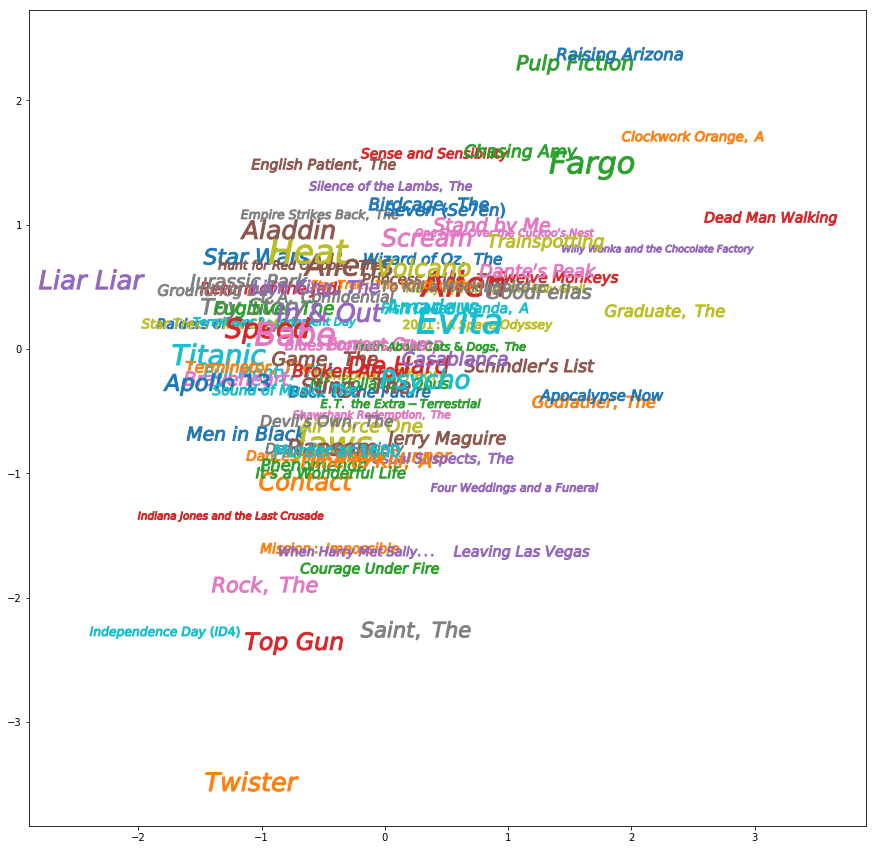

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
markers = ["$ {} $".format("\ ".join(m.split(" ")[:-1])) for m in top100["movie_title"]]
for i,item in enumerate(factors):
    l = len(markers[i])
    plt.scatter(item[0], item[1], marker = markers[i], s = 800 * l)
plt.show()

# Implementations in `scikit-surprise`

[Surprise](http://surpriselib.com/) contains implementations of many of the same things, so these are tested below. This same dataset is included as a built-in, but for consistency, we may as well load it from our dataframe.

- How would I turn movies into factor scores?

In [ ]:
import surprise
from surprise.dataset import Dataset

In [ ]:
reader = surprise.Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ml[["user_id", "movie_id", "rating"]], reader)

In [ ]:
surprise.model_selection.cross_validate(surprise.NormalPredictor(), data, cv=5)

In [ ]:
surprise.model_selection.cross_validate(surprise.SlopeOne(), data, cv=5)

In [ ]:
surprise.model_selection.cross_validate(surprise.SVD(), data, cv=5)